### Unzipping and preprocessing of Data

In [0]:
!unzip -qq "/content/drive/My Drive/colab/CelebDataset/CelebAMask-HQ.zip"

In [3]:
!git clone https://github.com/rosenta/CelebA_Image_Segmentation.git
!cp -r CelebA_Image_Segmentation/* .

Cloning into 'CelebA_Image_Segmentation'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 53 (delta 27), reused 39 (delta 16), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [0]:
!python data_preprocessing.py

### importing Necessary files

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dja2p7a9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dja2p7a9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=1ea86f709cacf480e92bcd672da3b3f14cf9deff2c4bf82187808aa8979774c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqne2nzt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
from data_preprocessing import *
from models import *
from utils.constant import Constant
from main import *

Using TensorFlow backend.


In [0]:
# creating preprocessed custom dataset Object
dataset_object = CelebADataset()

In [6]:
train_gen, val_gen = dataset_object.data_gen(Constant.TRAIN_FRAMES_DIR, Constant.TRAIN_MASKS_DIR, Constant.VAL_FRAMES_DIR, Constant.VAL_MASKS_DIR)

Found 21000 images belonging to 1 classes.
Found 21000 images belonging to 1 classes.
Found 9000 images belonging to 1 classes.
Found 9000 images belonging to 1 classes.


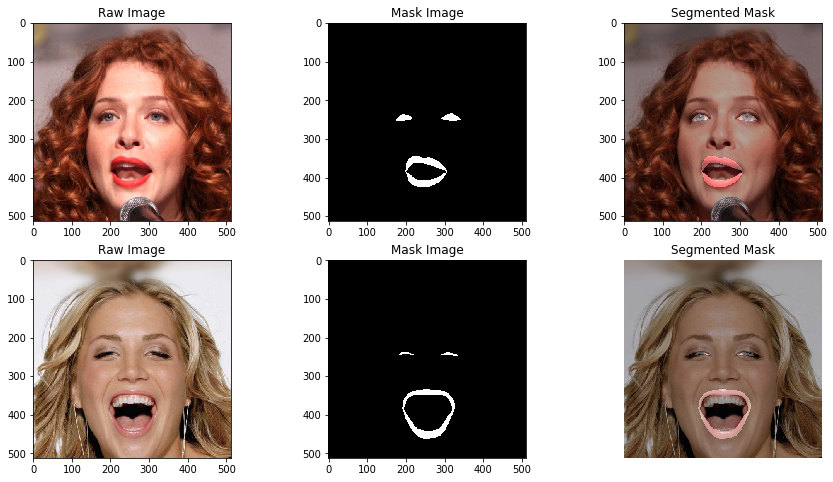

In [10]:
dataset_object.visualise_data(num_images=2)

In [0]:
#!python main.py

In [0]:
# define model
model = models.unet()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
________________________________________________________________________

/content/models.py:121: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [7]:
no_of_train_images = len(os.listdir(os.path.join(Constant.TRAIN_FRAMES_DIR, 'train')))
no_of_val_images = len(os.listdir(os.path.join(Constant.VAL_FRAMES_DIR, 'test')))

weights_path = 'best_model.hdf5'

checkpoint = ModelCheckpoint(weights_path, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')

  # define logger
csv_logger = CSVLogger('./log.out', append=True, separator=';')

  # define early stopping
earlystopping = EarlyStopping(monitor = 'val_acc', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]

results = model.fit_generator(train_gen, epochs=Constant.NUM_EPOCHS, 
                        steps_per_epoch=no_of_train_images//Constant.BATCH_SIZE,
                        validation_data=val_gen, 
                        validation_steps=no_of_val_images//Constant.BATCH_SIZE, 
                        callbacks=callbacks_list)




Epoch 1/3





5250/5250 [==============================] - 3613s 688ms/step - loss: 0.5806 - acc: 0.9744 - val_loss: 0.4801 - val_acc: 0.9811

Epoch 00001: val_acc improved from -inf to 0.98111, saving model to best_model.hdf5
Epoch 2/3
5250/5250 [==============================] - 3591s 684ms/step - loss: 0.4008 - acc: 0.9746 - val_loss: 0.3299 - val_acc: 0.9811

Epoch 00002: val_acc did not improve from 0.98111
Epoch 3/3
5250/5250 [==============================] - 3590s 684ms/step - loss: 0.2760 - acc: 0.9746 - val_loss: 0.2280 - val_acc: 0.9811

Epoch 00003: val_acc did not improve from 0.98111


In [0]:
prediction = model.evaluate_generator(val_gen,5)

2


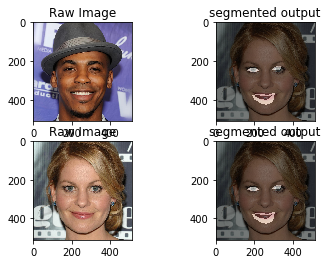

In [16]:
fig, axs = plt.subplots(2, 2)

image_list = []
act_mask_list = []
color = np.zeros([512,512,1])

n = 0
for raw_img, actual_mask in val_gen:

  image_list.append(raw_img[0])
  rgb_mask = np.concatenate((actual_mask[0],)*3, axis=-1)
  act_mask_list.append(rgb_mask)
  alpha = 0.5
  beta = 0.5
  gamma = 0.0


  res = cv2.addWeighted( raw_img[0], alpha, rgb_mask, beta, gamma)
  n += 1
  if n == 2:
    break

print(len(image_list))
for plot in range(2):

    axs[plot, 0].imshow(image_list[plot], interpolation='nearest')
    axs[plot, 0].set_title('Raw Image')

    axs[plot, 1].imshow(act_mask_list[plot], interpolation='nearest')
    axs[plot, 1].set_title('actual Image')        

    axs[plot, 1].imshow(res, interpolation='nearest')
    axs[plot, 1].set_title('segmented output')        
      
plt.show()

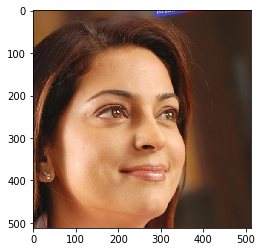

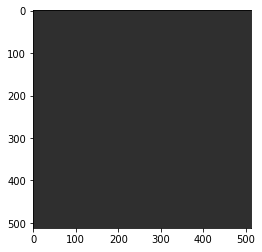

In [9]:
raw_image = plt.imread("/content/custom_CelebAMask_dataset/test_frames/test/13837.jpg")
raw_image = cv2.resize(raw_image, (512,512),0)
plt.imshow(raw_image)
plt.show()
a = model.predict(raw_image.reshape(1,512,512,3))[0]
a = np.concatenate((a,)*3, axis=-1)
plt.imshow(a)